<a href="https://colab.research.google.com/github/syamkakarla98/DataScience_Head_Start/blob/master/Deep_Learning/Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taffic Sign Classification

Traffic Sign Classification Using **Convolutional Neural Networks(CNNs)**, Which is widely used in various applications in the field of Artificial Intelligence. This notebook focuses on developing a deep learning model in order to classify the traffic signs.🛑❌🚫🚷🚳



![taffic_signs](https://www.nevron.com/NIMG.axd?i=Diagram/Shapes/TrafficSignsShapes/Traffic_signs_shapes.png)


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
!ls -l /kaggle/input/traffic-signs-classification

total 4460
-rw-r--r--  1 nobody nogroup     863 Apr  1 06:35 extract.py
-rw-r--r--  1 nobody nogroup    1037 Apr  1 06:35 labels.csv
-rw-r--r--  1 nobody nogroup 4552523 Apr  1 06:35 model_trained.p
drwxr-xr-x 45 nobody nogroup    4096 Apr  1 06:38 myData


## Importing Libraries

In [0]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

TensoFlow Version:  2.1.0


## Reading Data of Class Labels

In [0]:
path = '/kaggle/input/traffic-signs-classification'
lab = pd.read_csv('/kaggle/input/traffic-signs-classification/labels.csv')


## Visualizing countplot of the classes

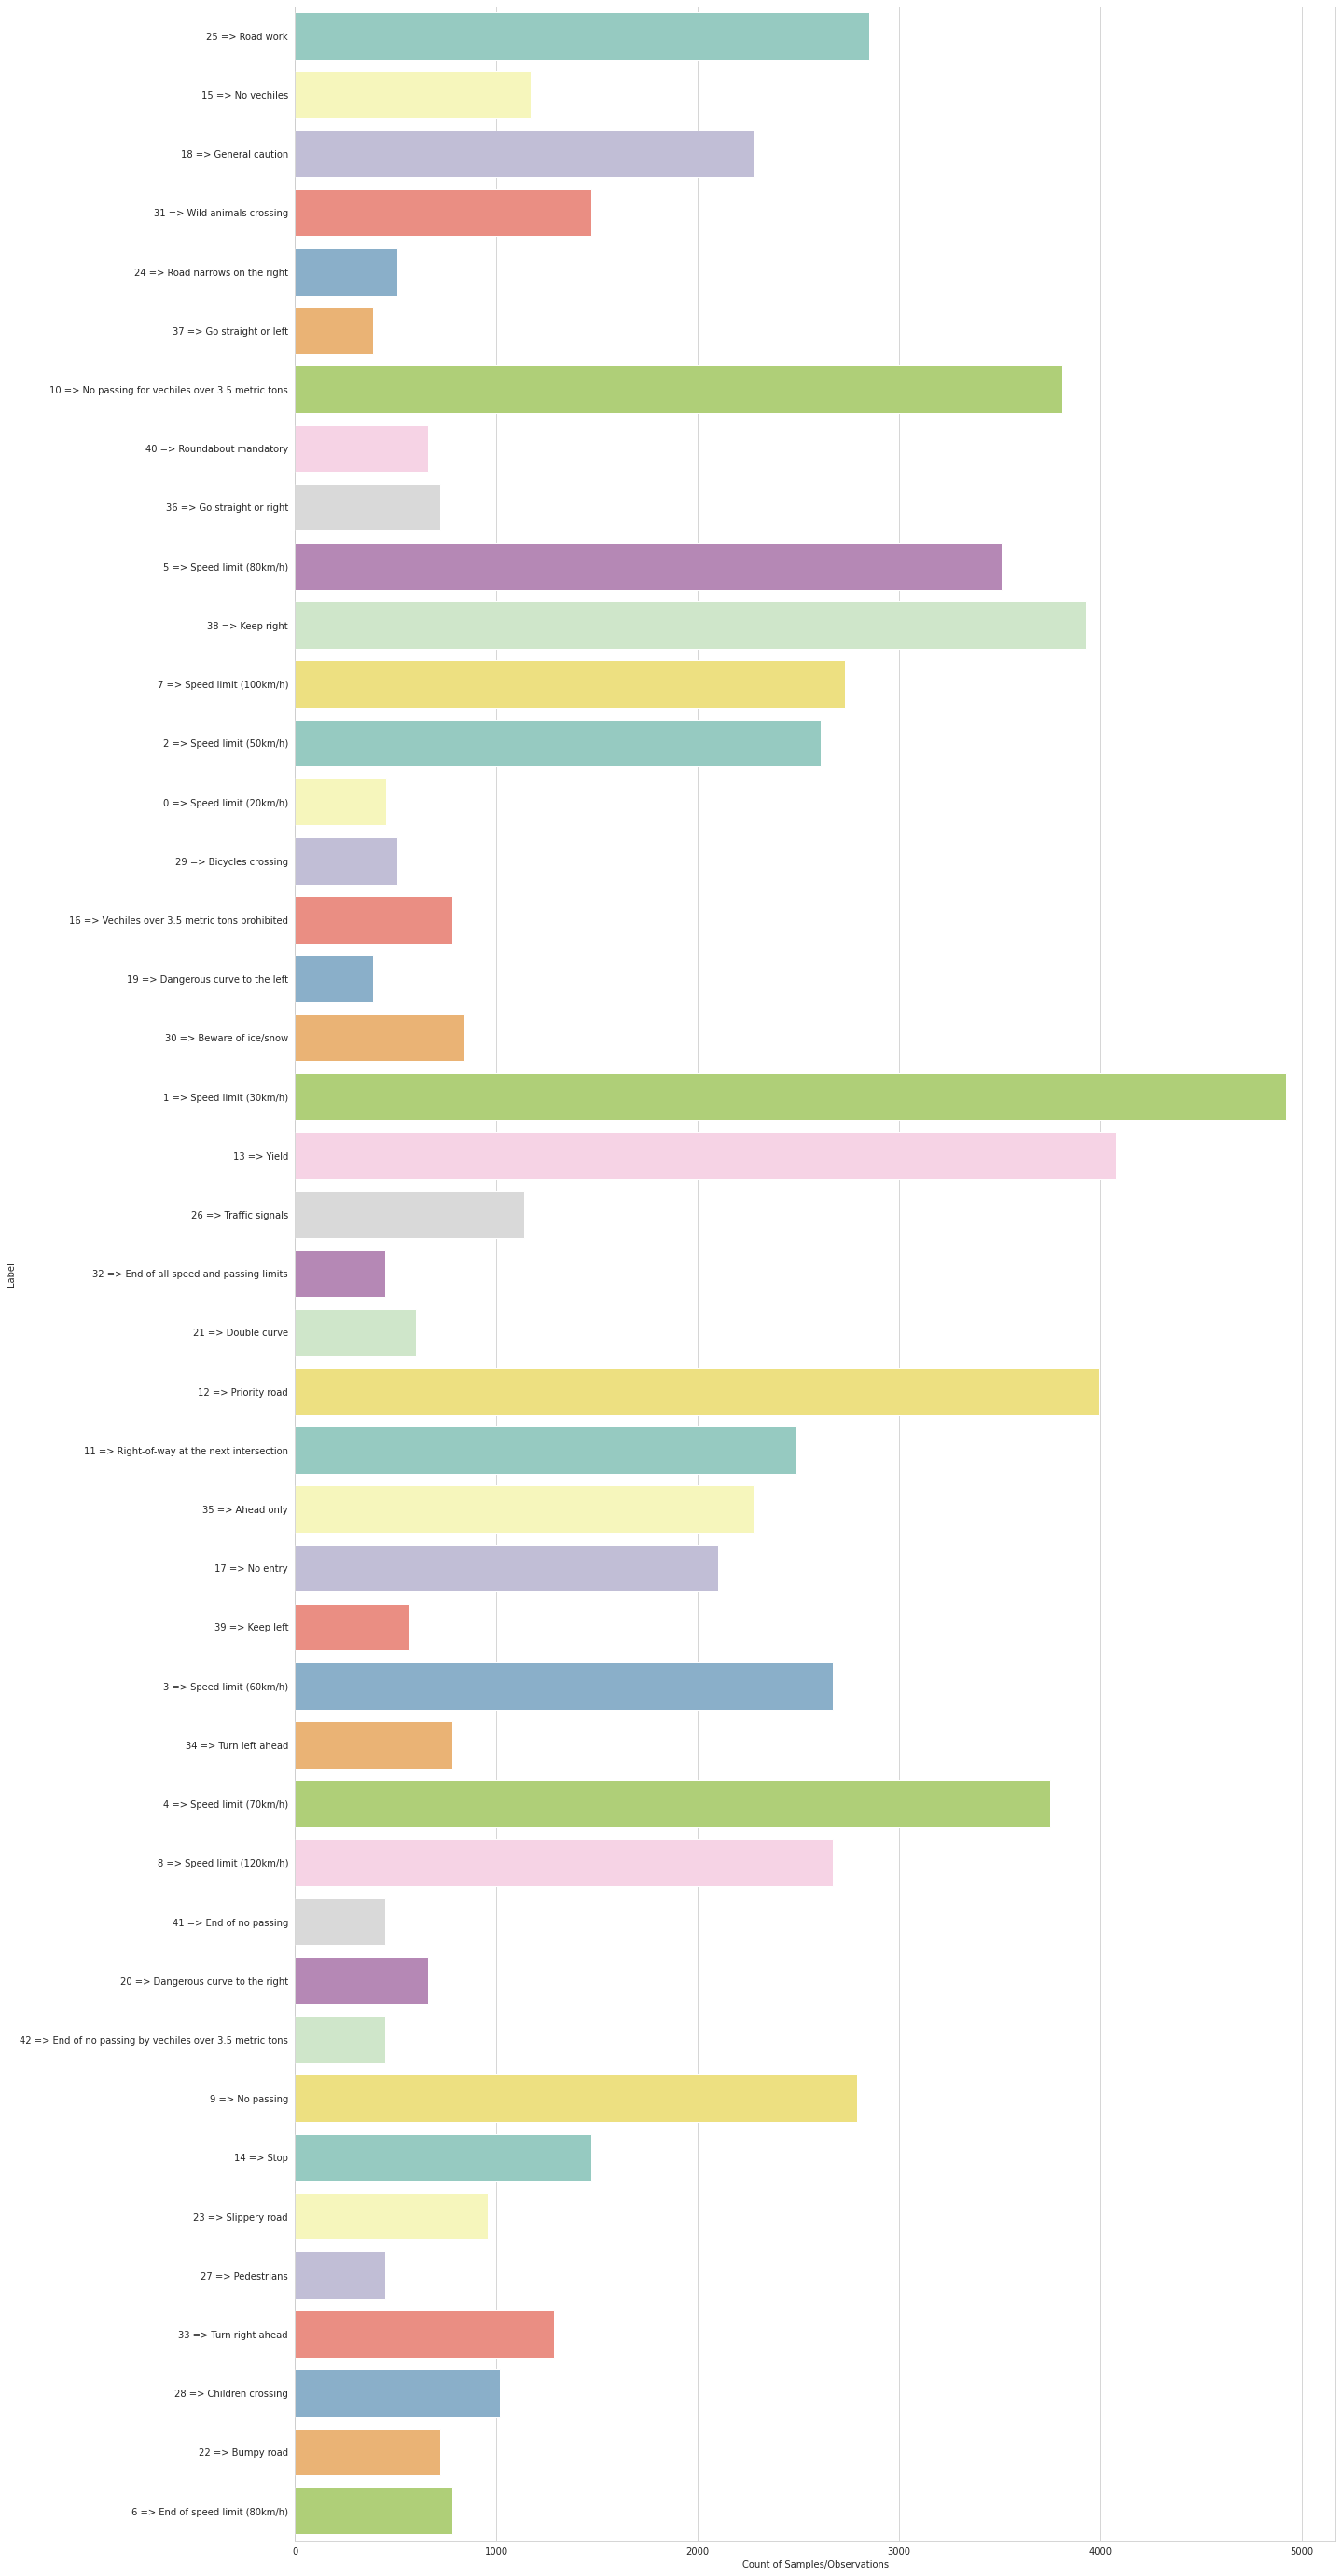

In [0]:
# Count PLot of the samples/observations w.r.t the classes
d = dict()
class_labels = dict()
for dirs in os.listdir(path + '/myData'):
    count = len(os.listdir(path+'/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize = (20, 50))
sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations');

## Reading Image Data

In [0]:
# input image dimensions
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3
nb_classes = len(class_labels.keys())

datagen = ImageDataGenerator()
data = datagen.flow_from_directory('/kaggle/input/traffic-signs-classification/myData',
                                    target_size=(32, 32),
                                    batch_size=73139,
                                    class_mode='categorical',
                                    shuffle=True )

Found 73139 images belonging to 43 classes.


In [0]:
X , y = data.next()

In [0]:
# Labels are one hot encoded
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(73139, 32, 32, 3)
Labels shape :(73139, 43)


## Sample Images of Dataset

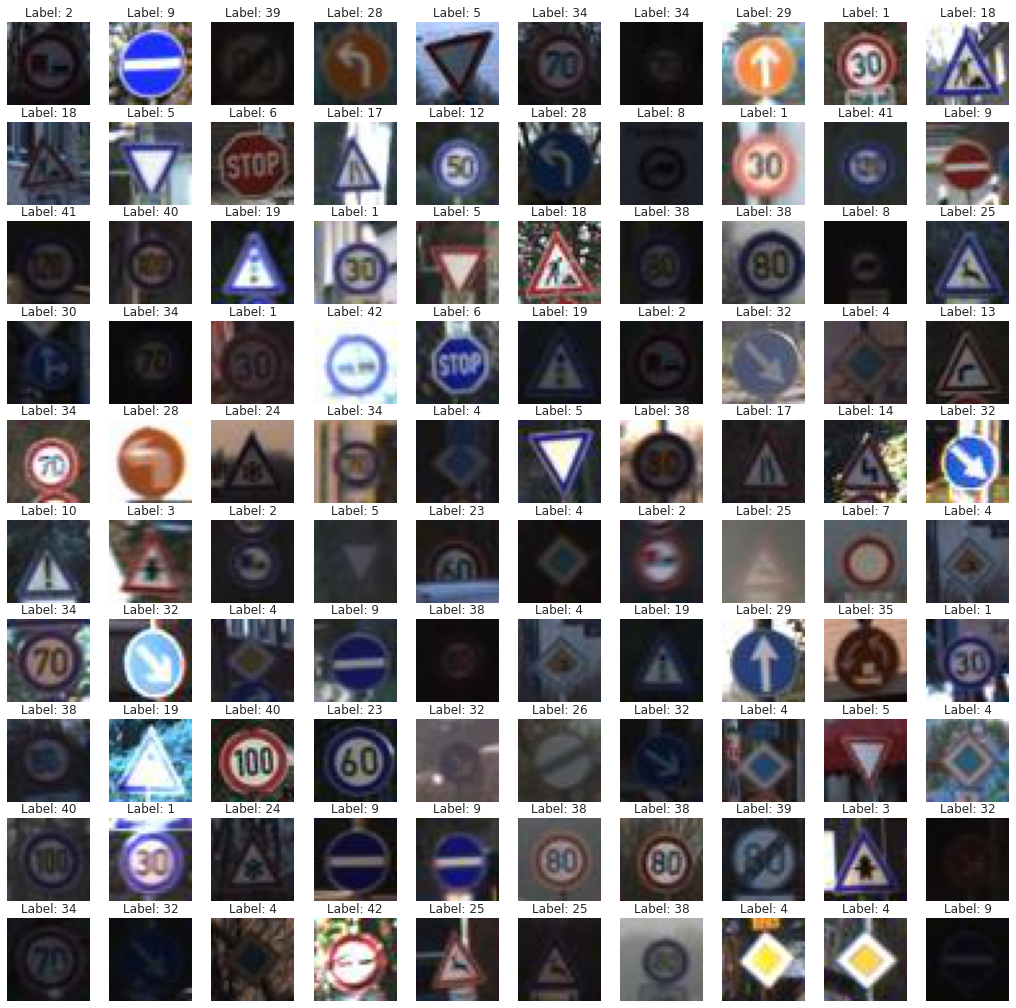

In [0]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))
    


## Dividing data into **train** and **test** in the split percentage of 80:20

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [0]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (58511, 32, 32, 3)
Test Shape : (14628, 32, 32, 3)


## Customising ResNet50 model  

In [0]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [0]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Visualising Model Architecture

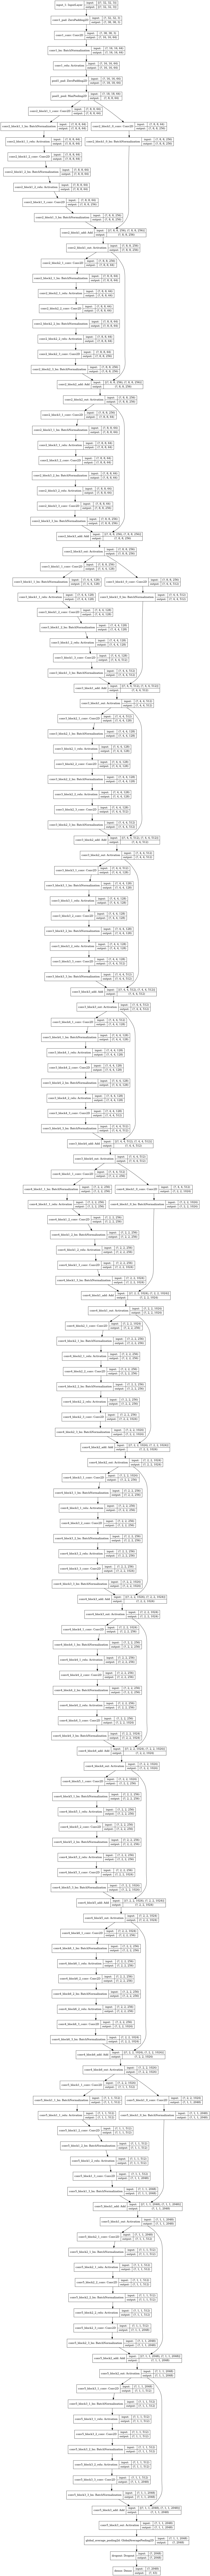

In [0]:

plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png')

## Compiling the Model

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Creating Callbacks

In [0]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')


## Fitting Model with Data

In [0]:
n_epochs = 50
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = n_epochs, verbose = 1, 
              validation_data = (X_test, y_test), callbacks = [model_check, early, reduce_lr, csv_logger])

Train on 58511 samples, validate on 14628 samples
Epoch 1/50
58511/58511 [==============================] - 83s 1ms/sample - loss: 3.8527 - accuracy: 0.2165 - val_loss: 1.7477 - val_accuracy: 0.4896
Epoch 2/50
58511/58511 [==============================] - 72s 1ms/sample - loss: 2.2039 - accuracy: 0.5344 - val_loss: 4.4478 - val_accuracy: 0.0740
Epoch 3/50
58511/58511 [==============================] - 73s 1ms/sample - loss: 1.0036 - accuracy: 0.7376 - val_loss: 0.5116 - val_accuracy: 0.8384
Epoch 4/50
58511/58511 [==============================] - 73s 1ms/sample - loss: 0.4797 - accuracy: 0.8687 - val_loss: 0.2496 - val_accuracy: 0.9248
Epoch 5/50
58511/58511 [==============================] - 71s 1ms/sample - loss: 0.3722 - accuracy: 0.9078 - val_loss: 8.1103 - val_accuracy: 0.4307
Epoch 6/50
58511/58511 [==============================] - 73s 1ms/sample - loss: 0.8035 - accuracy: 0.8082 - val_loss: 0.1625 - val_accuracy: 0.9483
Epoch 7/50
58511/58511 [==============================] 

In [0]:
# Saving the model
model.save('TSC_model.h5')

In [0]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

14628/14628 [==============================] - 6s 426us/sample - loss: 0.0226 - accuracy: 0.9941
Accuracy:  0.9940525 
Loss    :  0.02264666503515686


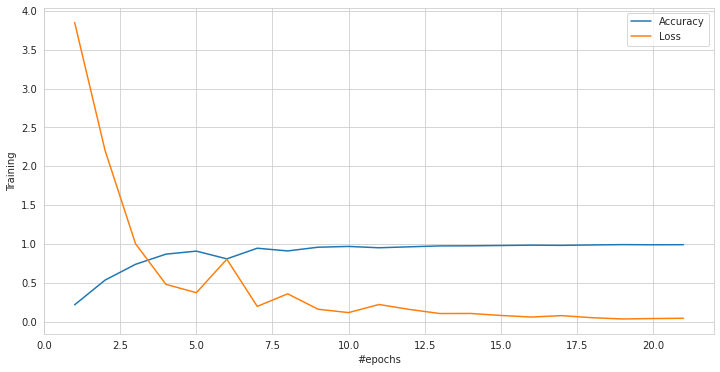

In [0]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

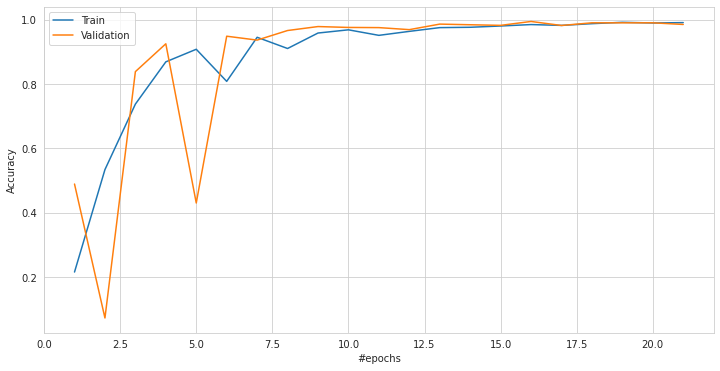

In [0]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

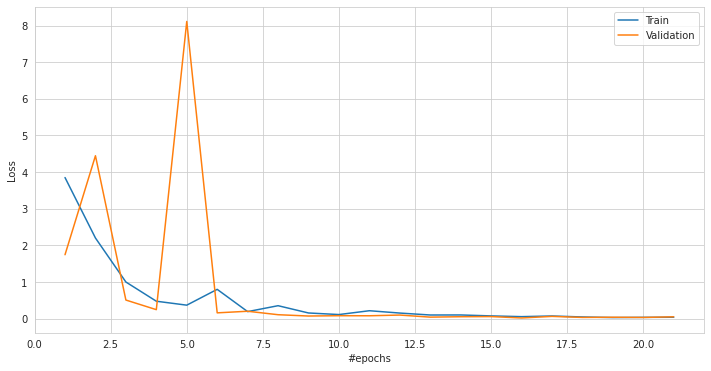

In [0]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

## Predict class labels of the test data

In [0]:
%%time
pred = np.argmax(model.predict(X_test), axis = 1)

CPU times: user 6.04 s, sys: 970 ms, total: 7.01 s
Wall time: 6.76 s


## Classification Report

In [0]:
print(classification_report(np.argmax(y_test, axis = 1), pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        88
           1       0.99      0.99      0.99       995
           2       1.00      1.00      1.00       780
           3       1.00      0.99      1.00       503
           4       1.00      1.00      1.00       772
           5       1.00      1.00      1.00       840
           6       1.00      1.00      1.00       296
           7       1.00      1.00      1.00       216
           8       1.00      1.00      1.00       154
           9       1.00      1.00      1.00       412
          10       1.00      0.99      0.99       453
          11       1.00      1.00      1.00        67
          12       0.99      0.99      0.99       540
          13       0.99      0.99      0.99       141
          14       0.99      0.98      0.99       129
          15       1.00      0.99      1.00       136
          16       0.99      0.99      0.99       189
          17       1.00    

## Confusion Matrix

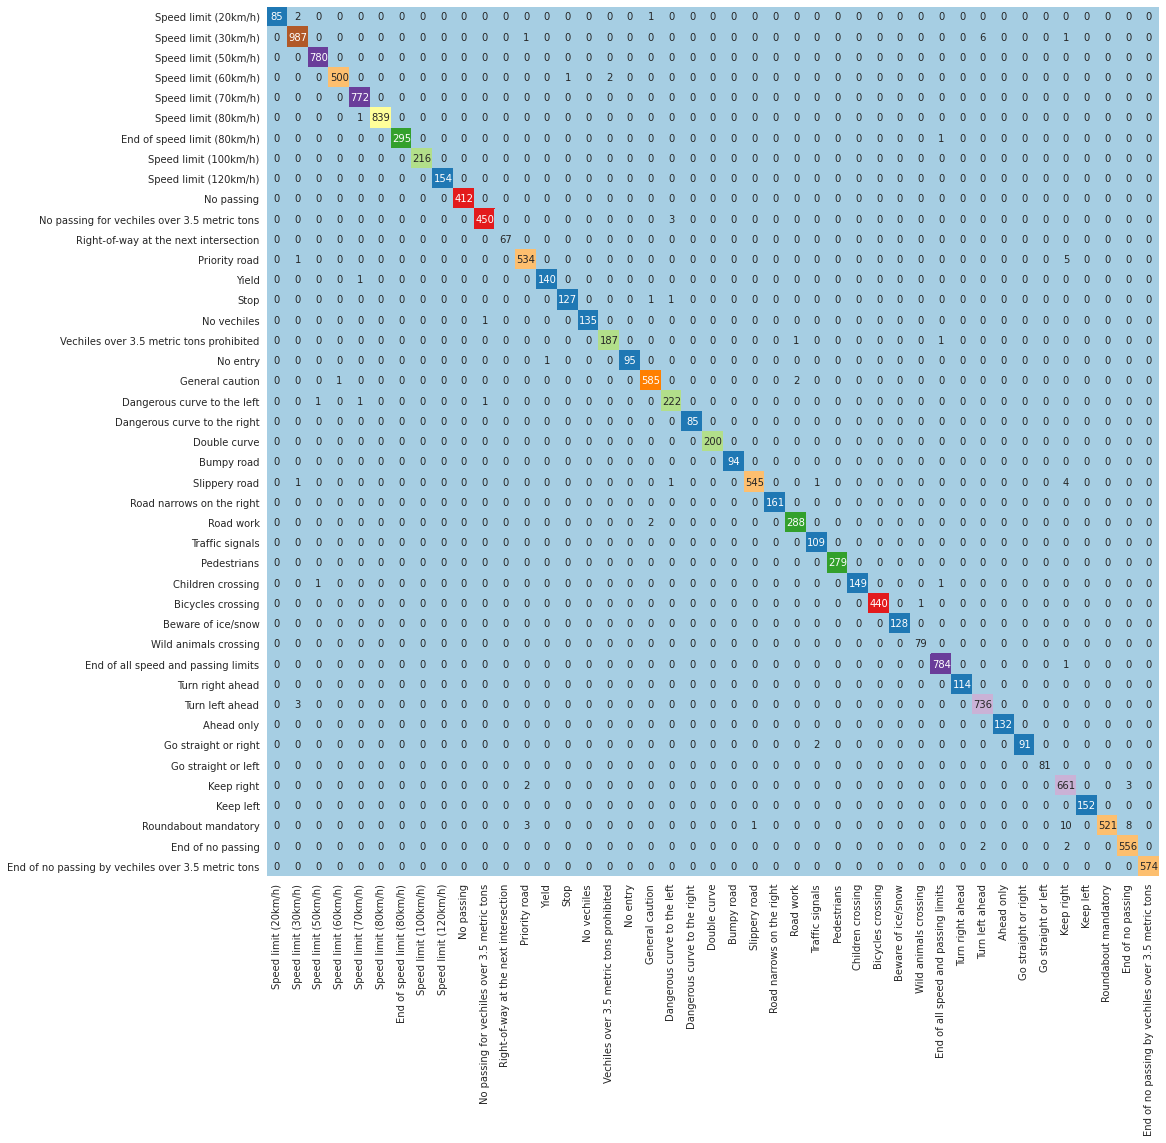

In [0]:
cmat = confusion_matrix(np.argmax(y_test, axis=1), pred)
labels = [class_labels[i] for i in range(43)]
plt.figure(figsize=(16,16))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=labels, yticklabels=labels);

## Classwise Accuracy

In [0]:
classwise_acc = cmat.diagonal()/cmat.sum(axis=1) * 100 
cls_acc = pd.DataFrame({'Class_Label':[class_labels[i] for i in range(43)], 'Accuracy': classwise_acc.tolist()}, columns = ['Class_Label', 'Accuracy'])
cls_acc.style.format({"Accuracy": "{:,.2f}",}).hide_index().bar(subset=["Accuracy"], color='tomato')

## Finally, Lets see the predictions of **unseen data**

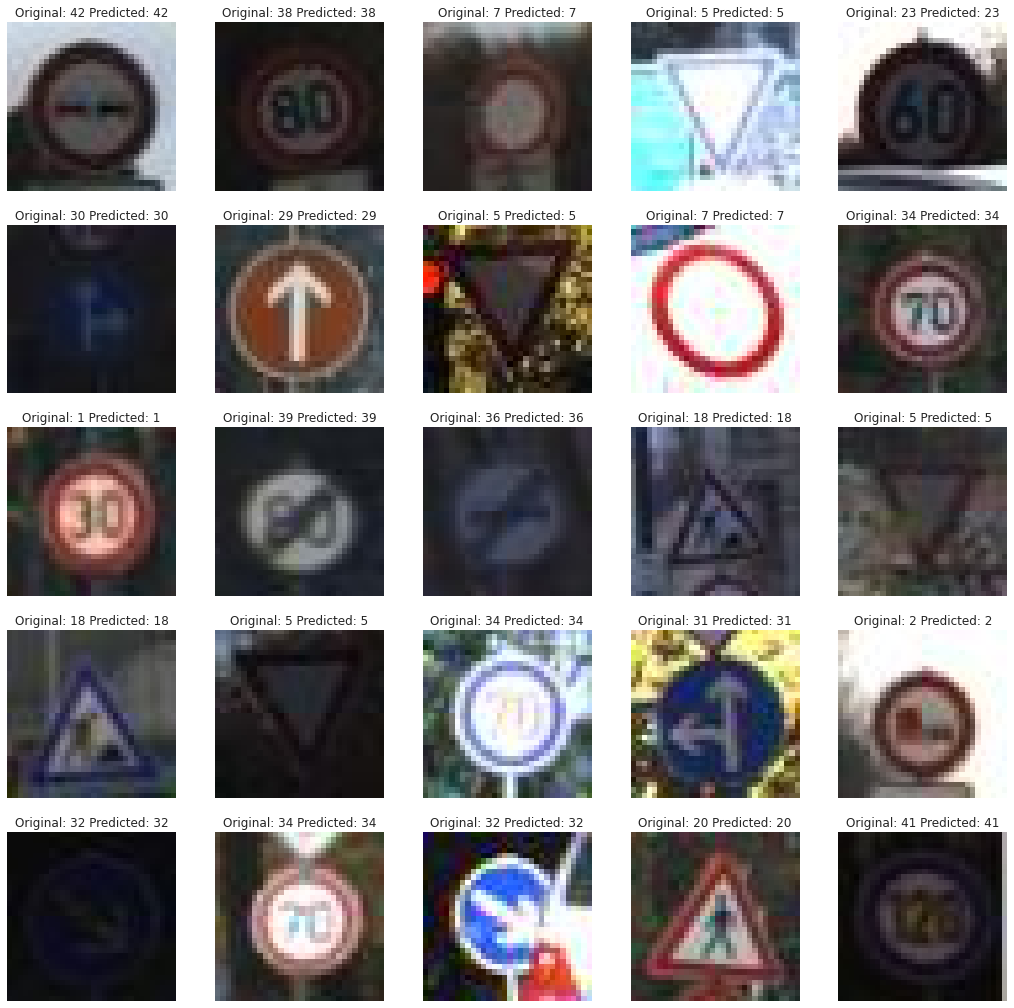

In [0]:
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))

--- 